In [1]:
from runner import *

plotpath = parent_directory + "\\plots\\"
plotting.set_dir(plotpath)

loading complete, calculating accuracy
getting human labeled boundaries
complete


In [3]:
# pre_segmentation_image = np.array((thresholdedProcessImage > 0) + 2 * (somaImage > 0), dtype=float)
#
# plotting.colorplot(plotting.panel(pre_segmentation_image, bbox, 1), two_map, interpolation="None",
#                    name="temp")

In [4]:
image_rect = [0.0, 0.0, somaImage.shape[0], somaImage.shape[1]]
mini_rna = RNA.sample(100000)
qtree, rna_list = trees.convert_to_qtree(RNA, image_rect, 10)
mini_qtree, mini_rna_list = trees.convert_to_qtree(mini_rna, image_rect, 10)

1991684it [02:38, 12534.08it/s]
100000it [00:07, 13254.01it/s]


In [5]:
barcodes = Counter(RNA['barcode_id'])
soma_cells = Counter(RNA[RNA['process_index'] == 0]['cell_index'])
process_cells = Counter(RNA[RNA['process_index'] > 0]['cell_index'])

soma_counts = np.zeros(np.max(list(soma_cells.keys())) + 1)
process_counts = np.zeros(np.max(list(soma_cells.keys())) + 1)
barcodes_counts = np.zeros(1240)
for key in barcodes:
    barcodes_counts[key] = barcodes[key]

for key in soma_cells:
    soma_counts[key] = soma_cells[key]

for key in soma_cells:
    process_counts[key] = process_cells[key]

max_soma_cells = np.argsort(soma_counts)[::-1]
max_process_cells = np.argsort(process_counts)[::-1]
max_codes = np.argsort(barcodes_counts)[::-1]

array([569, 505, 781, ..., 107, 171, 113], dtype=int64)

In [17]:
n = 100000
rna_subset = np.random.choice(rna_list, n, False)

n_neighbors = np.zeros(n)
all_neighbors = [None for _ in range(n)]
type_list = ["unlabeled" for _ in range(n)]
for i, pt in tqdm(enumerate(rna_subset)):
    neighbors = qtree.radius_query((pt.y, pt.x), 5, getter=trees.Getter())
    n_neighbors[i] = len(neighbors)
    all_neighbors[i] = neighbors

    if pt.cell > 0:
        if pt.processIndex > 0:
            type_list[i] = "process"
        else:
            type_list[i] = "soma"

density = n_neighbors/(np.pi * 25)
rna_subset_table = pd.DataFrame({"density" : density,
                                 "type" : type_list,
                                 "barcode" : [point.barcode for point in rna_subset],
                                "cell": [point.cell for point in rna_subset]})

100000it [04:06, 405.86it/s]


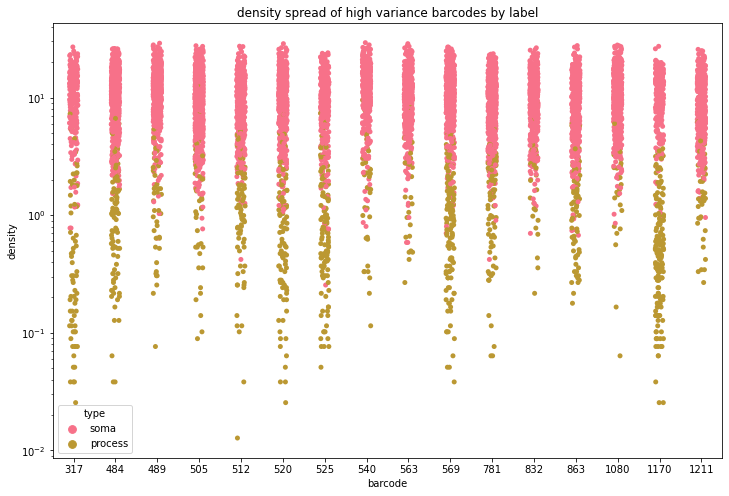

In [18]:
n = 16
high_var_codes = max_codes[:n]
high_var_samples = rna_subset_table[np.isin(rna_subset_table["barcode"], high_var_codes)]
high_var_samples = high_var_samples[high_var_samples['type'] != 'unlabeled']
fig, ax = plt.subplots(figsize = (12, 8))
sns.set_palette("husl")
ax.set_facecolor((0,0,0,0))
sns.stripplot(data=high_var_samples, y="density", x="barcode", hue="type", ax = ax)
ax.set_yscale('log')
ax.set_title("density spread of high variance barcodes by label")
fig.savefig(plotpath + "densityspread100.png")
plt.show()

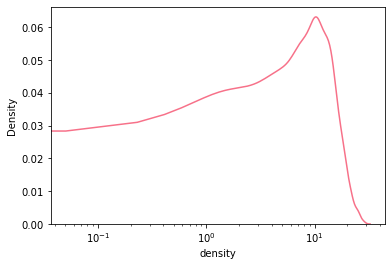

In [13]:
fig = plt.figure
sns.kdeplot(data=high_var_samples, x='density')
plt.xscale('log')
plt.show()